In [69]:
# This Python 3 environment comes with many helpful analytics libraries installed0
# For example, here's several helpful packages to load in 
import math
import random
import pickle
import itertools

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 

from sklearn.utils import shuffle

from scipy.signal import resample

import matplotlib.pyplot as plt

np.random.seed(42)

import pickle
#from sklearn.preprocessing import OneHotEncoder
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation , Dropout
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("/Users/Usuario/Documents/Python Scripts/F2/database"))

# Any results you write to the current directory are saved as output.

['mitbih_test.csv', 'mitbih_test.csv.zip', 'mitbih_train.csv', 'mitbih_train.csv.zip', 'ptbdb_abnormal.csv', 'ptbdb_abnormal.csv.zip', 'ptbdb_normal.csv', 'ptbdb_normal.csv.zip']


In [70]:
df = pd.read_csv("/Users/Usuario/Documents/Python Scripts/F2/database/mitbih_train.csv", header=None)
df2 = pd.read_csv("/Users/Usuario/Documents/Python Scripts/F2/database/mitbih_test.csv", header=None)
df = pd.concat([df, df2], axis=0)

In [71]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB


In [73]:
df[187].value_counts()
equilibre = df[187].value_counts()

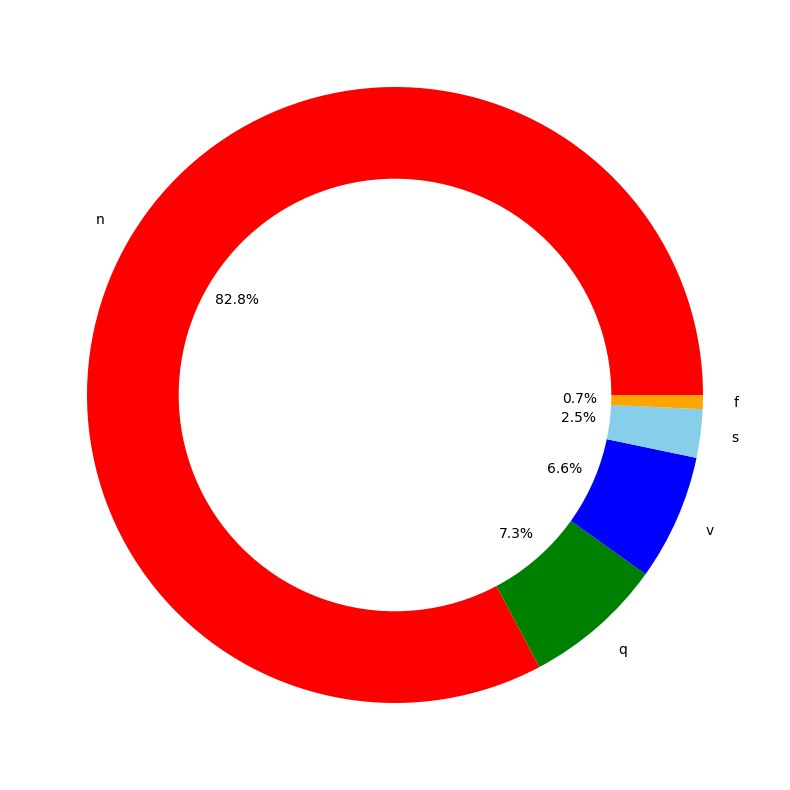

In [74]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [75]:
M = df.values
X = M[:, :-1]
y = M[:, -1].astype(int)

In [76]:
del df
del df2
del M

# Visual Input

In [77]:
C0 = np.argwhere(y == 0).flatten()
C1 = np.argwhere(y == 1).flatten()
C2 = np.argwhere(y == 2).flatten()
C3 = np.argwhere(y == 3).flatten()
C4 = np.argwhere(y == 4).flatten()

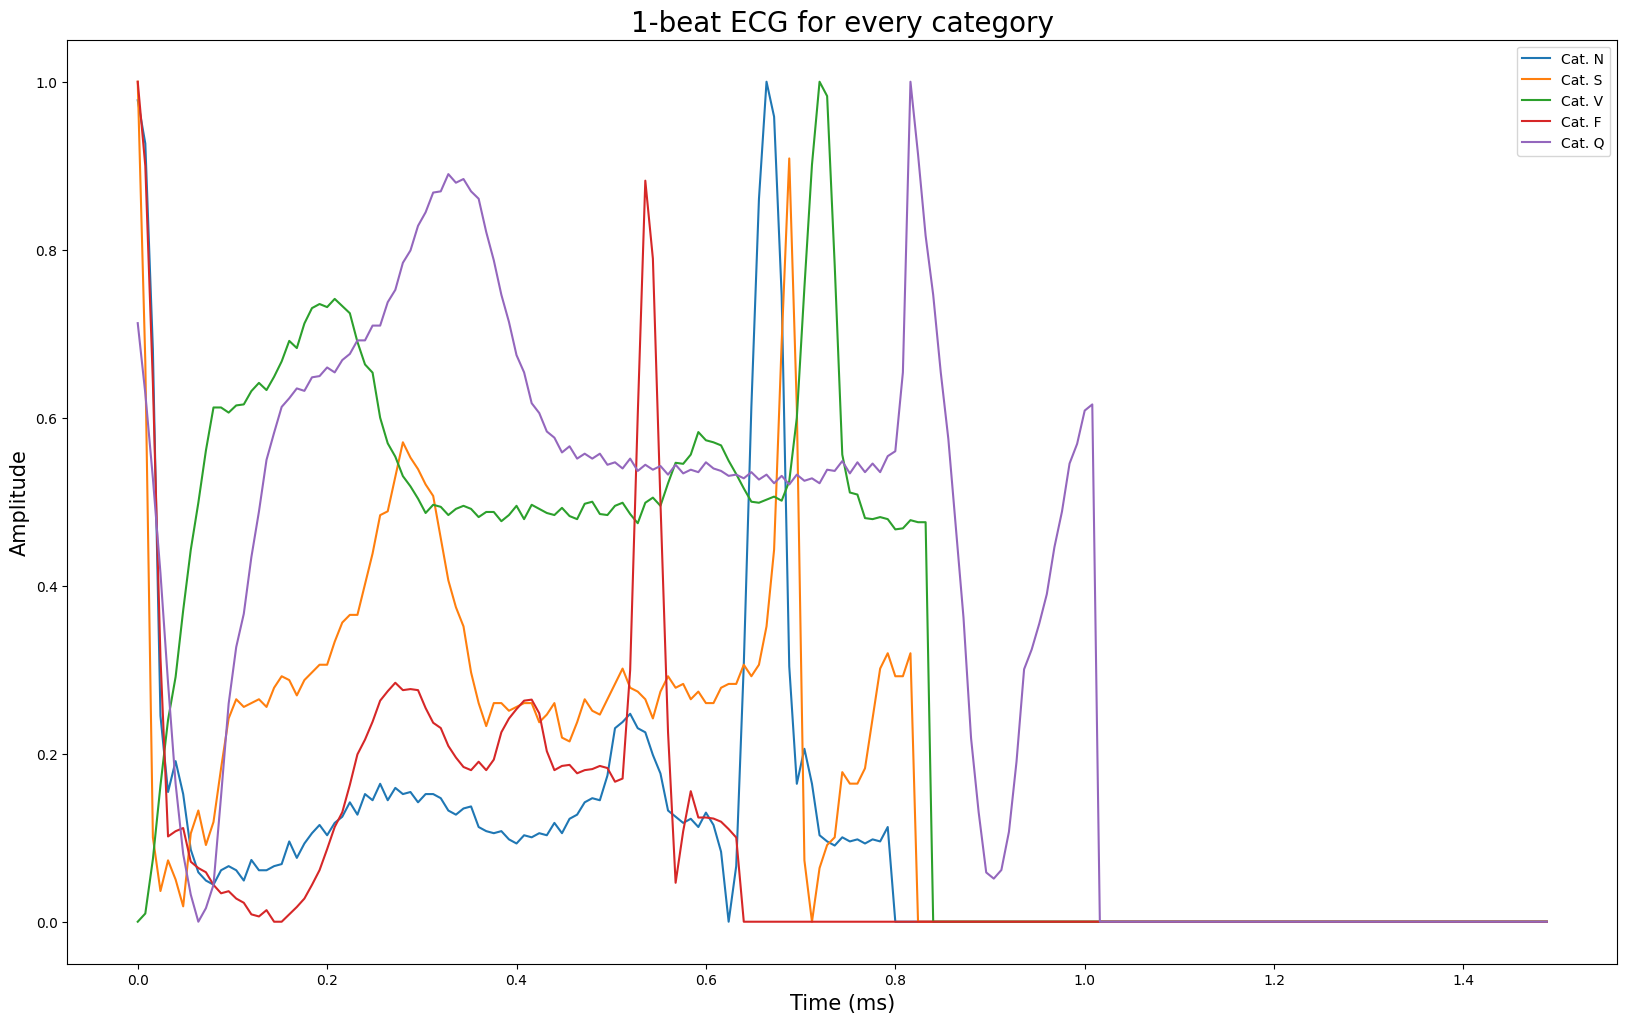

In [78]:
x = np.arange(0, 187)*8/1000

plt.figure(figsize=(20,12))
plt.plot(x, X[C0, :][0], label="Cat. N")
plt.plot(x, X[C1, :][0], label="Cat. S")
plt.plot(x, X[C2, :][0], label="Cat. V")
plt.plot(x, X[C3, :][0], label="Cat. F")
plt.plot(x, X[C4, :][0], label="Cat. Q")
plt.legend()
plt.title("1-beat ECG for every category", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

# Data augmentation

To train properly the model, we sould have to augment all data to the same level. Nevertheless, for a first try, we will just augment the smallest class to the same level as class 1. With that we will be able to have a test set of around 5x800 observations.

In [79]:
def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor

def augment(x):
    result = np.zeros(shape= (4, 187))
    for i in range(3):
        if random.random() < 0.33:
            new_y = stretch(x)
        elif random.random() < 0.66:
            new_y = amplify(x)
        else:
            new_y = stretch(x)
            new_y = amplify(new_y)
        result[i, :] = new_y
    return result

# Split

In [80]:
subC0 = np.random.choice(C0, 800)
subC1 = np.random.choice(C1, 800)
subC2 = np.random.choice(C2, 800)
subC3 = np.random.choice(C3, 800)
subC4 = np.random.choice(C4, 800)

In [81]:
X_test = np.vstack([X[subC0], X[subC1], X[subC2], X[subC3], X[subC4]])
y_test = np.hstack([y[subC0], y[subC1], y[subC2], y[subC3], y[subC4]])

X_train = np.delete(X, [subC0, subC1, subC2, subC3, subC4], axis=0)
y_train = np.delete(y, [subC0, subC1, subC2, subC3, subC4], axis=0)

X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

del X
del y

In [82]:
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

In [83]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (105938, 187, 1)
y_train (105938,)
X_test (4000, 187, 1)
y_test (4000,)


In [84]:
#ohe = OneHotEncoder()
#y_train = ohe.fit_transform(y_train.reshape(-1,1))
#y_test = ohe.transform(y_test.reshape(-1,1))
y_train=to_categorical(y_train)
#y_train=y_train.toarray()
#y_test=y_test.toarray()
y_test=to_categorical(y_test)

In [85]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (105938, 187, 1)
y_train (105938, 5)
X_test (4000, 187, 1)
y_test (4000, 5)


# Model

Now let's re-create the model from the ArXiv Document

In [86]:
n_obs, feature, depth = X_train.shape
batch_size = 500
#batch_size = 500

In [87]:
K.clear_session()

inp = Input(shape=(feature, depth))
C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)
C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
A11 = Activation("relu")(C11)
C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
M11 = MaxPooling1D(pool_size=5, strides=2)(A12)


C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
A21 = Activation("relu")(C21)
C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
S21 = Add()([C22, M11])
A22 = Activation("relu")(S21)
M21 = MaxPooling1D(pool_size=5, strides=2)(A22)


C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
A31 = Activation("relu")(C31)
C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
S31 = Add()([C32, M21])
A32 = Activation("relu")(S31)
M31 = MaxPooling1D(pool_size=5, strides=2)(A32)


C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
A41 = Activation("relu")(C41)
C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
S41 = Add()([C42, M31])
A42 = Activation("relu")(S41)
M41 = MaxPooling1D(pool_size=5, strides=2)(A42)


C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
A51 = Activation("relu")(C51)
C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
S51 = Add()([C52, M41])
A52 = Activation("relu")(S51)
M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

M52 = (Dropout(0.25))(M51)

F1 = Flatten()(M52)

D1 = Dense(32)(F1)
A6 = Activation("relu")(D1)
D2 = Dense(32)(A6)
D3 = Dense(5)(D2)
A7 = Softmax()(D3)

model = Model(inputs=inp, outputs=A7)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 183, 32)      192         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 183, 32)      5152        ['conv1d[0][0]']                 
                                                                                                  
 activation (Activation)        (None, 183, 32)      0           ['conv1d_1[0][0]']               
                                                                                              

In [88]:
def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.75
    t = n_obs//(10000 * batch_size)  # every epoch we do n_obs/batch_size iteration
    lrate = initial_lrate * math.exp(-k*t)
    return lrate

lrate = LearningRateScheduler(exp_decay)

In [89]:
adam = Adam(learning_rate = 0.01, beta_1 = 0.9, beta_2 = 0.99)
#adam = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)

In [90]:
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [91]:
history = model.fit(X_train, y_train, 
                    epochs=75, 
                    batch_size=batch_size, 
                    verbose=2, 
                    validation_data=(X_test, y_test), 
                    callbacks=[lrate])

Epoch 1/75
212/212 - 27s - loss: 0.1068 - accuracy: 0.9141 - val_loss: 0.4934 - val_accuracy: 0.5455 - lr: 0.0010 - 27s/epoch - 127ms/step
Epoch 2/75
212/212 - 27s - loss: 0.0486 - accuracy: 0.9644 - val_loss: 0.4175 - val_accuracy: 0.6655 - lr: 0.0010 - 27s/epoch - 128ms/step
Epoch 3/75
212/212 - 27s - loss: 0.0360 - accuracy: 0.9749 - val_loss: 0.3032 - val_accuracy: 0.7160 - lr: 0.0010 - 27s/epoch - 125ms/step
Epoch 4/75
212/212 - 27s - loss: 0.0302 - accuracy: 0.9785 - val_loss: 0.2557 - val_accuracy: 0.7492 - lr: 0.0010 - 27s/epoch - 126ms/step
Epoch 5/75
212/212 - 27s - loss: 0.0269 - accuracy: 0.9807 - val_loss: 0.2395 - val_accuracy: 0.7835 - lr: 0.0010 - 27s/epoch - 126ms/step
Epoch 6/75
212/212 - 26s - loss: 0.0249 - accuracy: 0.9822 - val_loss: 0.1946 - val_accuracy: 0.8395 - lr: 0.0010 - 26s/epoch - 125ms/step
Epoch 7/75
212/212 - 26s - loss: 0.0232 - accuracy: 0.9829 - val_loss: 0.1658 - val_accuracy: 0.8500 - lr: 0.0010 - 26s/epoch - 123ms/step
Epoch 8/75
212/212 - 26s - 

In [92]:
y_pred = model.predict(X_test, batch_size=1000)

4/4 [==============================] - 1s 91ms/step


In [93]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86       800
           1       0.99      0.86      0.92       800
           2       0.83      0.96      0.89       800
           3       1.00      0.67      0.80       800
           4       1.00      0.98      0.99       800

    accuracy                           0.90      4000
   macro avg       0.92      0.90      0.89      4000
weighted avg       0.92      0.90      0.89      4000



In [94]:
print("ranking-based average precision : {:.3f}".format(label_ranking_average_precision_score(y_test, y_pred)))
print("Ranking loss : {:.3f}".format(label_ranking_loss(y_test, y_pred)))
print("Coverage_error : {:.3f}".format(coverage_error(y_test, y_pred)))

ranking-based average precision : 0.944
Ranking loss : 0.034
Coverage_error : 1.138


Normalized confusion matrix


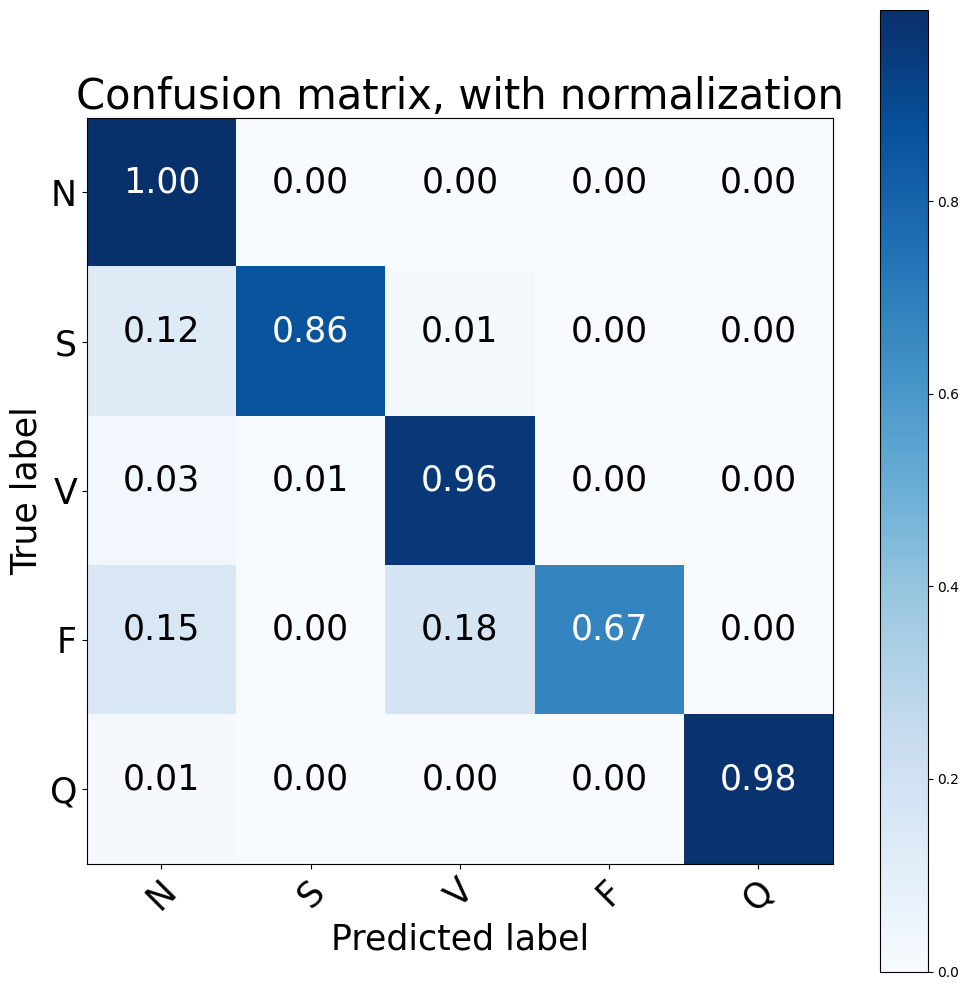

In [111]:
import itertools
def plot_cnf_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=25)
    plt.yticks(tick_marks, classes, fontsize=25)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=25)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_cnf_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()

In [112]:
print(cnf_matrix)

[[799   0   1   0   0]
 [ 97 691  12   0   0]
 [ 22   5 771   2   0]
 [121   0 142 537   0]
 [  9   0   3   0 788]]


In [113]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
RECALL = TP/(TP+FN)c
# Specificity or true negative rate
SPECIFICITY = TN/(TN+FP) 
# Precision or positive predictive value
PRECISION = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
#F1-score
F1 = 2*((RECALL*PRECISION)/(RECALL+PRECISION))

In [114]:
from statistics import mean, median
scores = model.evaluate((X_test),y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
PRE = mean(PRECISION)
print("Precision: %.2f%%"% (PRE*100))
#print("Precision: ", PRECISION)
SPE = mean(SPECIFICITY)
print("Specificity: %.2f%%"% (SPE*100))
#print("Specificity", SPECIFICITY)
RE = mean(RECALL)
print("Recall :%.2f%%"% (RE*100))
#print("Recall", RECALL)
#print("F1: ", F1)
F1S = mean(F1)
print("F1-Score :%.2f%%"% (F1S*100))

Accuracy: 89.65%
Precision: 91.63%
Specificity: 97.41%
Recall :89.65%
F1-Score :89.50%
